# Класифiкацiя кольорових зображень з використанням згорткових нейронних мереж в TensorFlow. Технологiя передачi знань (transfer learning)

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from sklearn.model_selection import train_test_split
import datetime
import pandas as pd
from keras.applications.vgg16 import VGG16

#### Допоміжні функції

In [102]:
def plot_metrics(losses_list, accuracies_list, titles):
    num_plots = len(losses_list)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label="Training Loss - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("All Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label="Training Accuracy - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("All Accuracies")

    plt.show()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, val_losses, label="Validation Loss - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("All Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, val_accuracies, label="Validation Accuracy - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("All Accuracies")

    plt.show()

In [103]:
def history_plot(history):
    return [history.history['loss'], history.history['val_loss']], [history.history['accuracy'], history.history['val_accuracy']]

In [104]:
def history_last(history):
    return ['loss', history.history['loss'][-1]], ['val_loss', history.history['val_loss'][-1]], ['accuracy', history.history['accuracy'][-1]], ['val_accuracy', history.history['val_accuracy'][-1]]

In [101]:
import warnings
from absl import logging
logging.set_verbosity(logging.ERROR)
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

#### Завантаження датасету

In [105]:
input_shape = (28, 28, 1)
num_classes = 10

In [106]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train, y_test, y_val = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10), tf.one_hot(y_val, depth=10)


#### Модель з одним згортковим шаром

In [107]:
plots = []
loss_acc = []
test_results = []

In [108]:
log_dir = "logs_tb/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [109]:
batch_size = 128
epochs = 10

In [110]:
baseModel = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
 
baseModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
historyBase =  baseModel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,\
                    validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)
 
test_loss_Base, test_acc_Base =  baseModel.evaluate(X_test, y_test)
print('Test loss:', test_loss_Base, ' Test accuracy:', test_acc_Base)

313/313 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9797
Test loss: 0.06839552521705627  Test accuracy: 0.9797000288963318


In [111]:
test_results.append([test_loss_Base, test_acc_Base])
plots.append(history_plot(historyBase))

#### Розширені згорткові моделі

In [112]:
complexModel_1 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(num_classes, activation='softmax')
])

complexModel_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historyComplex1 = complexModel_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,\
                       validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)
 
test_loss_complex1, test_acc2_complex = complexModel_1.evaluate(X_test, y_test)
print('Test loss:', test_loss_complex1, ' Test accuracy:', test_acc2_complex)

313/313 [==============================] - 1s 4ms/step - loss: 0.0238 - accuracy: 0.9913
Test loss: 0.023836316540837288  Test accuracy: 0.9912999868392944


In [113]:
test_results.append([test_loss_complex1, test_acc2_complex])
plots.append(history_plot(historyComplex1))

In [114]:
complexModel_2 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', ),
    keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

complexModel_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historyComplex2 = complexModel_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, \
                       validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)

test_loss_coplex2, test_acc_coplex2 = complexModel_2.evaluate(X_test, y_test)
print('Test loss:', test_loss_coplex2, ' Test accuracy:', test_acc_coplex2)

313/313 [==============================] - 2s 7ms/step - loss: 0.0257 - accuracy: 0.9938
Test loss: 0.025673160329461098  Test accuracy: 0.9937999844551086


In [115]:
test_results.append([test_loss_coplex2, test_acc_coplex2])
plots.append(history_plot(historyComplex2))

#### Змiна параметрiв padding i strides згорткового шару, а також розмiрнiсті ядра згортки

In [116]:
newKernelModel = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
 
newKernelModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
historyKernel = newKernelModel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,\
                       validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)

test_loss_kernel, test_acc_kernel = newKernelModel.evaluate(X_test, y_test)
print('Test loss:', test_loss_kernel, ' Test accuracy:', test_acc_kernel)

313/313 [==============================] - 1s 2ms/step - loss: 0.0474 - accuracy: 0.9865
Test loss: 0.04737665504217148  Test accuracy: 0.9865000247955322


In [117]:
test_results.append([test_loss_kernel, test_acc_kernel])
plots.append(history_plot(historyKernel))

In [118]:
paddingModel = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
 
paddingModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
historyPadding = paddingModel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,\
                       validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)
 
test_loss_padding, test_acc_padding = paddingModel.evaluate(X_test, y_test)
print('Test loss:', test_loss_padding, ' Test accuracy:', test_acc_padding)

313/313 [==============================] - 1s 2ms/step - loss: 0.0707 - accuracy: 0.9786
Test loss: 0.07070718705654144  Test accuracy: 0.978600025177002


In [119]:
test_results.append([test_loss_padding, test_acc_padding])
plots.append(history_plot(historyPadding))

In [120]:
stridesModel = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

stridesModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

historyStrides = stridesModel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,\
                       validation_data=(X_val, y_val), callbacks = [tensorboard_callback], verbose=0)

test_loss_strides, test_acc_strides = stridesModel.evaluate(X_test, y_test)
print('Test loss:', test_loss_strides, ' Test accuracy:', test_acc_strides)

313/313 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9787
Test loss: 0.0696435198187828  Test accuracy: 0.9786999821662903


In [121]:
test_results.append([test_loss_strides, test_acc_strides])
plots.append(history_plot(historyStrides))

In [122]:
titeles = ['Model Base', 'Model Complex 1', 'Model Complex 2', 'Model kernel (5, 5)', 'Model padding "same"', 'Model strides 2']

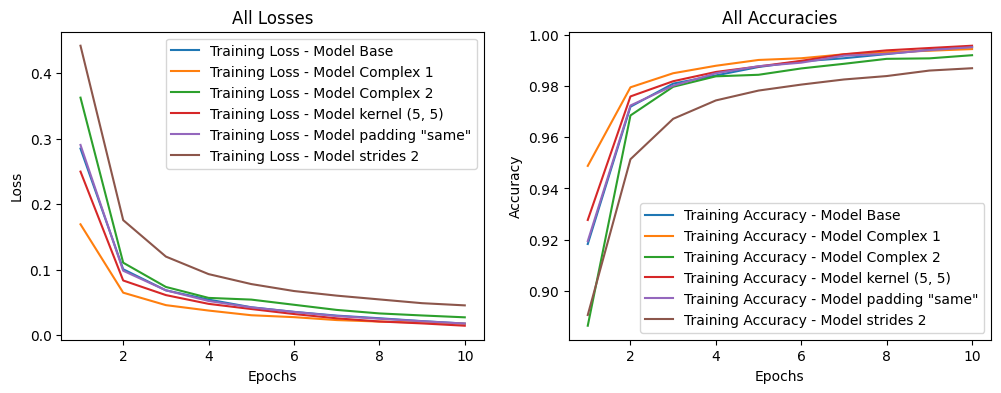

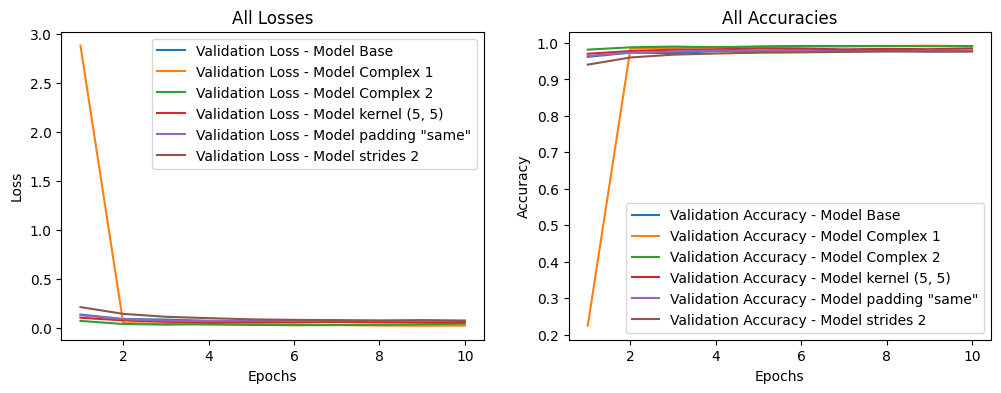

In [123]:
plot_metrics([plots [i][0] for i in range(len(plots))], [plots [i][1] for i in range(len(plots))], titeles)

####  TensorBoard

In [124]:
%load_ext tensorboard
%tensorboard --logdir "logs_tb/"

#### Висновки 
Дослідимо параметри втрат і точності для кожної моделі

In [125]:
pd.DataFrame(test_results, columns=['Loss', 'Accuracy'], index=titeles)

,Loss,Accuracy
Model Base,0.068396,0.9797
Model Complex 1,0.023836,0.9913
Model Complex 2,0.025673,0.9938
"Model kernel (5, 5)",0.047377,0.9865
"Model padding ""same""",0.070707,0.9786
Model strides 2,0.069644,0.9787


Моделями з найвищими показникмаи стали комплексні моделі з нормалізацією за міні-батчами і дропаутами. Незважаючи на велику кількість шарів обидві моедлі відзначилися кращою швидкістю навчання. Непогані результати показала також стандартна модель зі зміненими параметрами padding, strides та ядром згортки.

#### Попередньо навчена VGG16

In [128]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [141]:
(X_train1, y_train1), (X_test1, y_test1) = tf.keras.datasets.cifar10.load_data()

X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)
X_train1 = X_train1.astype('float32') / 255.0
X_test1 = X_test1.astype('float32') / 255.0
X_val1 = X_val1.astype('float32') / 255.0
y_train1, y_test1, y_val1 = keras.utils.to_categorical(y_train1, num_classes=10), keras.utils.to_categorical(y_test1, num_classes=10), keras.utils.to_categorical(y_val1, num_classes=10)

In [142]:
input_shape1 = X_train1.shape[1:]
num_classes1 = 10

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [146]:
x = vgg16_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
predictions = keras.layers.Dense(num_classes1, activation='softmax')(x)
model_7 = Model(inputs=vgg16_model.input, outputs=predictions)

In [147]:
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_7 = model_7.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size,\
                        validation_data=(X_val1, y_val1), callbacks = [tensorboard_callback], verbose=0)

In [148]:
test_loss7, test_acc7 = model_7.evaluate(X_test1, y_test1)
print('Test loss:', test_loss7, ' Test accuracy:', test_acc7)

313/313 [==============================] - 20s 64ms/step - loss: 1.1332 - accuracy: 0.6026
Test loss: 1.1332405805587769  Test accuracy: 0.6025999784469604


In [151]:
titeles.append('Model VGG16')

In [149]:
predictions = []
models = [baseModel, complexModel_1, complexModel_2, newKernelModel, paddingModel, stridesModel]
for i in models:
    predictions.append(i.predict(X_test))

predictions.append(model_7.predict(X_test1))

313/313 [==============================] - 20s 63ms/step
